In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

C:\Users\luficerg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [51]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  #print(w)
  context = [0] * block_size

  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [52]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [53]:
C = torch.randn((27, 2))
C

tensor([[ 0.5069,  0.1214],
        [-0.5469,  0.3503],
        [-0.3057, -1.0968],
        [-0.5457, -1.5804],
        [ 0.6202,  1.2121],
        [ 0.5576,  1.5346],
        [ 1.1950, -2.5067],
        [ 1.5203,  2.3033],
        [-0.4379, -1.6889],
        [-0.3772, -0.1584],
        [ 0.7890,  0.5660],
        [ 0.3302, -1.8315],
        [-0.7021, -0.0695],
        [ 0.1654, -0.0200],
        [-0.3235,  0.9381],
        [-0.5067,  0.0744],
        [ 0.3372, -0.9517],
        [ 1.0044, -0.4492],
        [ 1.6216,  1.0449],
        [-0.1106, -0.1492],
        [-1.1735, -2.2405],
        [ 0.5109,  0.9723],
        [ 2.0844, -1.5946],
        [ 0.3786,  0.4059],
        [-0.3963, -0.0697],
        [ 0.6422,  1.4050],
        [-0.9918,  0.7051]])

In [54]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [55]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [56]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [57]:
h.shape

torch.Size([32, 100])

In [58]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [59]:
logits = h @ W2 + b2

In [60]:
logits.shape

torch.Size([32, 27])

In [61]:
counts = logits.exp()

In [62]:
prob = counts / counts.sum(1, keepdims=True)

In [63]:
prob.shape

torch.Size([32, 27])

In [64]:
Y.shape

torch.Size([32])

In [70]:
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss

tensor(15.5389)

In [ ]:
# ------------ now made respectable :) ---------------

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [ ]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [130]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [121]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [131]:
for p in parameters:
  p.requires_grad = True

In [132]:
emb = C[Xtr]
logits = (torch.tanh_(emb.view(-1, 30) @ W1 + b1)) @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(26.0047, grad_fn=<NllLossBackward0>)

In [102]:
torch.randint(0, Xtr.shape[0], (32,)) # Taking 32 random example from training example

tensor([ 55712, 100535, 111758,  87783,  92264,  31167, 158367, 164223,  87661,
         94584, 156825,   4134,  54052,  59635,  41654, 147704,  15525, 130145,
          5552,  18572, 150540,  58973, 142533,  12006, 152782, 127836,  62508,
        140642,  43721, 152806,   7628, 113359])

In [136]:
learning_rate = 0.2

for i in range(100):

    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward pass
    emb = C[Xtr[ix]]
    logits = (torch.tanh_(emb.view(-1, 30) @ W1 + b1)) @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    print(f'Loss at Iteration @ {i} is {loss.item()}')
    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    for p in parameters:
        p.data -= learning_rate * p.grad 


Loss at Iteration @ 0 is 10.629242897033691
Loss at Iteration @ 1 is 6.365262508392334
Loss at Iteration @ 2 is 9.430753707885742
Loss at Iteration @ 3 is 8.629942893981934
Loss at Iteration @ 4 is 8.548637390136719
Loss at Iteration @ 5 is 8.12479305267334
Loss at Iteration @ 6 is 7.364710807800293
Loss at Iteration @ 7 is 9.802048683166504
Loss at Iteration @ 8 is 8.362715721130371
Loss at Iteration @ 9 is 7.81827974319458
Loss at Iteration @ 10 is 8.364578247070312
Loss at Iteration @ 11 is 8.34182071685791
Loss at Iteration @ 12 is 6.344183921813965
Loss at Iteration @ 13 is 7.007071018218994
Loss at Iteration @ 14 is 7.5287699699401855
Loss at Iteration @ 15 is 8.050920486450195
Loss at Iteration @ 16 is 7.217986106872559
Loss at Iteration @ 17 is 6.136111736297607
Loss at Iteration @ 18 is 5.680299282073975
Loss at Iteration @ 19 is 8.09614372253418
Loss at Iteration @ 20 is 7.805634498596191
Loss at Iteration @ 21 is 8.265605926513672
Loss at Iteration @ 22 is 7.56301736831665
L

In [137]:
emb = C[Xdev]
logits = (torch.tanh_(emb.view(-1, 30) @ W1 + b1)) @ W2 + b2
loss = F.cross_entropy(logits, Ydev)

print(f'Loss for Dev set is {loss.item()}')

emb = C[Xte]
logits = (torch.tanh_(emb.view(-1, 30) @ W1 + b1)) @ W2 + b2
loss = F.cross_entropy(logits, Yte)

print(f'Loss for Test set is {loss.item()}')

Loss for Dev set is 6.429243564605713
Loss for Test set is 6.429574012756348


In [138]:
emb = C[X]
logits = (torch.tanh_(emb.view(-1, 30) @ W1 + b1)) @ W2 + b2
loss = F.cross_entropy(logits, Y)

print(f"Full data's loss is {loss.item()}")

Full data's loss is 6.285614490509033


## SO, it did work question is how you can determine the learning rate

In [139]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [144]:
lri = []
lossi = []
stepi = []

In [147]:
for i in range(20000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lr)
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

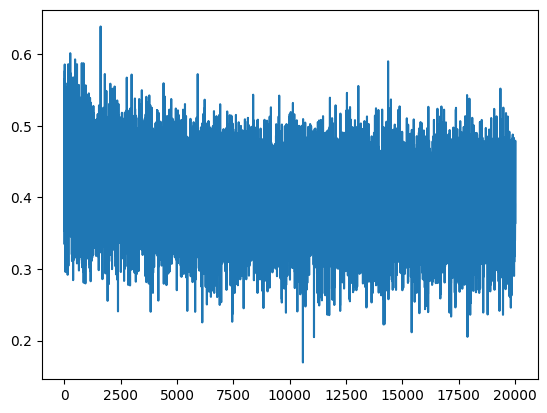

In [156]:
plt.plot(stepi, lossi)

In [157]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4848, grad_fn=<NllLossBackward0>)

In [151]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4941, grad_fn=<NllLossBackward0>)

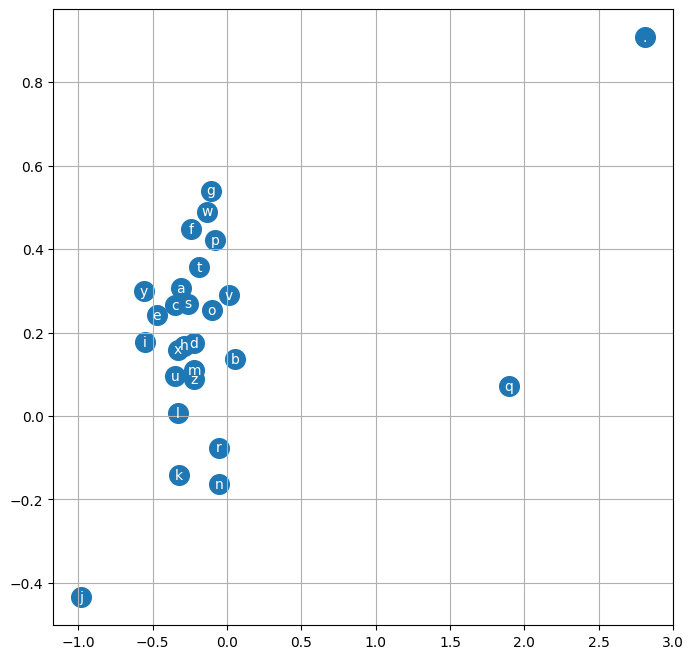

In [152]:
# visualize dimension 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [153]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [160]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

ger.
reelyn.
nessa.
reyah.
distonisleysynissayapmisai.
hacey.
lariyci.
bayse.
elina.
gilesameah.
romiyah.
aldixa.
milaumassahaisil.
mis.
diby.
relynick.
kasizaty.
releccire.
reehemorcessip.
wevis.


# Now, you name your son/daughteer by using this model

# Homework

# Question 1 beat loss of 2.2!!

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
# read in all the words
words = open('names.txt', 'r').read().splitlines()
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


C:\Users\luficerg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 4]) torch.Size([182580])
torch.Size([22767, 4]) torch.Size([22767])
torch.Size([22799, 4]) torch.Size([22799])


In [39]:
# Xtr , Xdev , Xte have dimensions 3 and the words length , it means it takes 3 characters as input and 1 character as output or predicted .
#The C is the context with 50 dimensions to represent the characters into context embeddings, so every 27 character has now 50 dimensions embedding for itself . .
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 20), generator=g)
C[Xtr].shape

torch.Size([182580, 4, 20])

In [ ]:
# It has converted those 3 character out of total 27 into 15 dimensions embeddings for each character, so basically.
# C shape is 27 , and 15 dimensions , it has Xtr which training set for indexing and 3 character of training set used as indexing for retrieving , the 15 dimension representation of that character from those 27 things
# This is what exactly we are doing here
C[Xtr]

In [4]:
context_shape = C[Xtr].shape[1] * C[Xtr].shape[2]
context_shape

60

In [5]:
# Whole Network
W1 = torch.randn((context_shape, 54), generator=g)
b1 = torch.randn(54, generator=g)
W2 = torch.randn((54, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [6]:
for p in parameters:
  p.requires_grad = True

In [36]:
learning_rate = 0.01
batch_size = 64

for i in range(10000):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # Forward pass
    logits = (torch.tanh(C[Xtr[ix]].view(-1, context_shape) @ W1 + b1)) @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    print(f'Loss at Iteration @ {i} is {loss.item()}')

    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = learning_rate if i < 5000 else 0.005

    if i > 5000:
        ix = torch.randint(0, Xdev.shape[0], (2200,))
        loss_eval = F.cross_entropy(((torch.tanh(C[Xdev[ix]].view(-1, context_shape) @ W1 + b1)) @ W2 + b2), Ydev[ix])
        print(f'Evaluation Loss at Iteration @ {i} is {loss_eval.item()}')
        if loss_eval <=2.1:
            break

    #update
    for p in parameters:
        p.data -= lr * p.grad 


Loss at Iteration @ 0 is 2.2771999835968018
Loss at Iteration @ 1 is 2.3110196590423584
Loss at Iteration @ 2 is 2.273418426513672
Loss at Iteration @ 3 is 2.3255348205566406
Loss at Iteration @ 4 is 2.156982660293579
Loss at Iteration @ 5 is 2.0027945041656494
Loss at Iteration @ 6 is 2.301069736480713
Loss at Iteration @ 7 is 2.2043583393096924
Loss at Iteration @ 8 is 2.024851083755493
Loss at Iteration @ 9 is 2.1413843631744385
Loss at Iteration @ 10 is 2.1743576526641846
Loss at Iteration @ 11 is 2.354738473892212
Loss at Iteration @ 12 is 2.368561029434204
Loss at Iteration @ 13 is 2.0290675163269043
Loss at Iteration @ 14 is 2.4071717262268066
Loss at Iteration @ 15 is 2.3285841941833496
Loss at Iteration @ 16 is 2.180391550064087
Loss at Iteration @ 17 is 1.9668318033218384
Loss at Iteration @ 18 is 2.5405120849609375
Loss at Iteration @ 19 is 2.305375099182129
Loss at Iteration @ 20 is 2.4158575534820557
Loss at Iteration @ 21 is 2.175551652908325
Loss at Iteration @ 22 is 2.1

In [37]:
emb = C[Xdev]
logits =(torch.tanh(emb.view(-1, context_shape) @ W1 + b1)) @ W2 + b2
print(logits.shape)
loss = F.cross_entropy(logits, Ydev)

print(f'Loss for Dev set is {loss.item()}')

emb = C[Xte]
logits = (torch.tanh(emb.view(-1, context_shape) @ W1 + b1)) @ W2 + b2
print(logits.shape)
loss = F.cross_entropy(logits, Yte)

print(f'Loss for Test set is {loss.item()}')

torch.Size([22655, 27])
Loss for Dev set is 2.251899003982544
torch.Size([22866, 27])
Loss for Test set is 2.250943422317505


In [22]:

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

zamy.
eederessaesorewtavie.
katlyna.
rondy.
jemforianmaineslayarilian.
heee.
viton.
maertothan.
ell.
anaaursi.
elyn.
pori.
arnushn.
kadamahyi.
aetu.
gzllian.
byci.
thya.
jezre.
saira.


## Question 2 A

In [35]:
# Total Garbage
p = torch.ones((Ytr.shape[0],27))
print(p.shape)
loss = F.cross_entropy(p, Ytr)

print(f'THe loss with equal probability distribution is {loss=}')

torch.Size([182625, 27])
THe loss with equal probability distribution is loss=tensor(3.2958)


## Question 2 B

# No, I can't find anyway to optimize the neural network to get 1.0 of loss as value